# Random mesaurements based manuel wire cutting implementation using Pennylane for dividing a GHZ quantumcircuit

* Author: Michel Meulen
* Date: 21-03-2025
* Contact: michel.meulen@tno.nl
-----------------------------------
This notebook illustrates a method for partitioning a Greenberger-Horne-Zeilinger (GHZ) quantum circuit, with an arbitrary number of qubits, into manageable subcircuits using the randomised-measurements-based wire cutting technique. The notebook then outlines how to reconstruct the measurement outcomes of the full circuit by appropriately combining the results obtained from measuring these subcircuit variants. The implementation is based on this paper: [Fast quantum circuit cutting with randomized measurements](https://arxiv.org/pdf/2207.14734) and tutorial: [Quantum Circuit Cutting](https://pennylane.ai/qml/demos/tutorial_quantum_circuit_cutting) created by Xanadu - Pennylane.

### Comparison of Pennylane implementation
Using the tutorial mentioned in the introduction, Pennylane uses Kraus operators for their different circuits to mimic both quantum channels using the QubitChannel() function. However these kraus operators are not applicable on real quantum hardware, since they're not unitary. If the aim is to run this on real quantum hardware, the use of these kraus operators is not recommended. Besides the QubitChannels also function as classical links between circuits. This is not realistic on real quantum hardware since these qubitchannels cannot be directly implemented. Some form of ancilla qubist are required to make this happen (think about the quantum teleportation circuit).

The Pennylane tutorial about wire cutting does not show actual results of using real quantum hardware. Maybe other research shows the effect of real quantum hardware, however Pennylane is not one of them. This is where our research can significantly differ from previous research. 

In [1]:
import pennylane as qml
from quantum_utils import QuantumUtils as qu
from quantum_wire_cutting import QuantumWireCutUtils as qwc
import numpy as np
from typing import Tuple
from quantum_channel import QuantumChannel

### Global configuration parameters for this notebook: 

In [2]:
# General parameters
NUMBER_OF_CUTS = 1
NUMBER_OF_CUT_QUBITS = 1
NUMBER_OF_QUBITS = 5

# Original circuit parameters
ORG_CIRCUIT_SHOTS = 1000

# Subcircuit parameters
SHOTS_BUDGET = 2000  # Min: 100,   Recommended: 1000,    Max: 10000
SUB_CIRCUIT_ITERATIONS = 20  # Min: 10,   Recommended: 20,      Max: 100
SHOTS_PER_ITERATION = SHOTS_BUDGET // SUB_CIRCUIT_ITERATIONS
QUANTUM_TELEPORTATION_ENABLED = False

## Quantum channel probability distribution

The randomized circuit measurements approach relies two seperate quantum channels. Pennylane implements these channel through two seperate Kraus operators. However, to mimic realistic quantum hardware quantum gates are used to generate the same results as the operators. We have two quantum channels where they both use variable: $d = 2^k$, where $k$ is the number of cut qubits:
* **Channel zero**: measure and prepare channel with random Clifford circuits; This channel has a probability of: $(d + 1)/(2d + 1)$
* **Channel one**: depolarization channel which randomizes the qubit initialization basis state; this channel has a probability of: $d/(2d + 1)$

In [3]:
def GetProbQuantumChannels(numCutQbits: int, shotBudget: int) -> Tuple[int, int]:
    numCutQbits = 2**NUMBER_OF_CUT_QUBITS
    chnProb0 = (numCutQbits + 1) / (2 * numCutQbits + 1)
    chnProb1 = numCutQbits / (2 * numCutQbits + 1)

    return round(chnProb0 * shotBudget), round(chnProb1 * shotBudget)


probDist = GetProbQuantumChannels(NUMBER_OF_CUT_QUBITS, SHOTS_PER_ITERATION)
print("Channel 0:", probDist[0], "\nChannel 1:", probDist[1])

Channel 0: 60 
Channel 1: 40


## Building the original GHZ quantum circuit

In this notebook a GHZ quantum circuit, consisting of three qubits is split among two subcircuits containing two qubits. To build the original circuit we use:

0: ──H─╭●──────────┤ ╭Probs
1: ────╰X─╭●───────┤ ├Probs
2: ───────╰X─╭●────┤ ├Probs
3: ──────────╰X─╭●─┤ ├Probs
4: ─────────────╰X─┤ ╰Probs


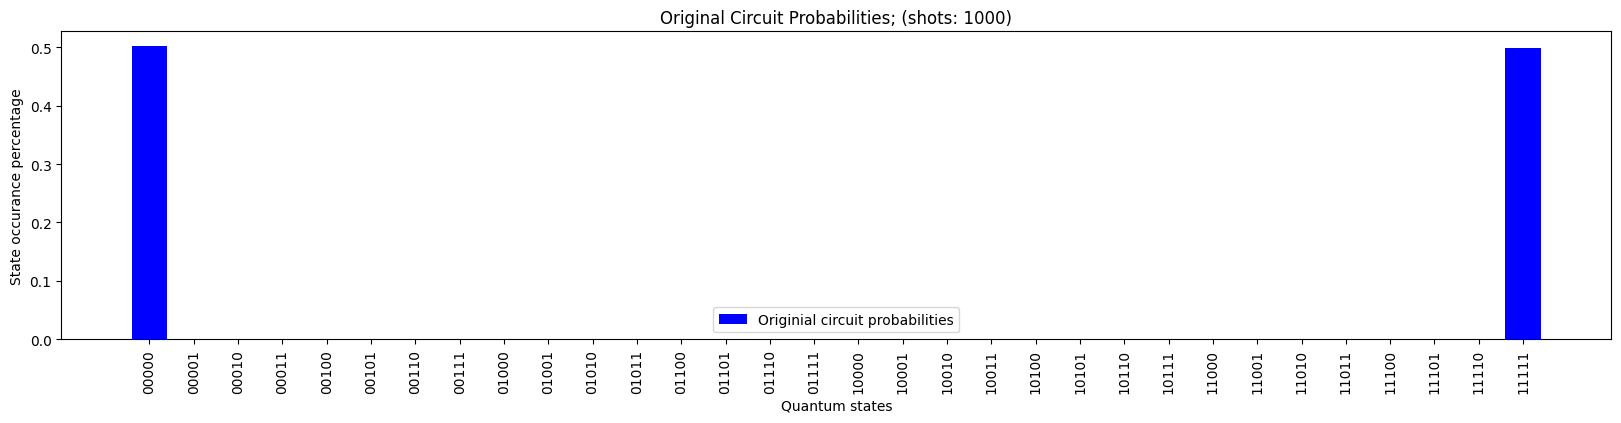

In [4]:
orgDevice = qml.device("default.qubit", wires=NUMBER_OF_QUBITS, shots=(ORG_CIRCUIT_SHOTS))


def OrgCircuit():
    qml.Hadamard(wires=[0])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    # qml.WireCut(wires=[2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    return qml.probs(wires=[0, 1, 2, 3, 4])


def OrgVisualise():
    circuit = qml.QNode(OrgCircuit, orgDevice)
    print(qml.draw(circuit)())


def OrgRun():
    circuit = qml.QNode(OrgCircuit, orgDevice)
    return circuit()


OrgVisualise()
orgProbs = OrgRun()
qu.ProbabilitesToBarChart(probabilities=orgProbs, dataLabels="Originial circuit probabilities", title=f"Original Circuit Probabilities; (shots: {ORG_CIRCUIT_SHOTS})")

## Defining the subcircuits

As before mentioned for executing the quantum channels two different subcircuits variants must be initliased. Careful readers may notice that there is only one subcircuit method defined. This is due the hybrid computing nature of this wire cutting technique. It is more pratical, when working with hybrid computing in Pennylane, to define one subcircuit with more depth than to define two seperate circuits. The next subcircuit makes it possible to execute a five qubit GHZ quantum circuit on three qubits.

In [5]:
def SubCircuit(qChannel: QuantumChannel):

    # Create a list to store the measurements
    measurement = []

    # First run the first subcircuit gates:
    qml.Hadamard(wires=[0])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    if qChannel == QuantumChannel.RANDOM_CLIFFORD:  # (Measure and Prepare with 2-Design) (Channel 0)

        # Adjointed random Clifford circuit (gets executed immediately after function call)
        cliffCirc = qwc.RandomCliffordCircuit(wires=[2], depth=NUMBER_OF_CUTS)
        qwc.ApplyCircuit(operations=cliffCirc, adjoint=True)

        # Measure both the first and second qubits, they contribute to the final outcome, and reset them
        measurement.append(qml.measure(wires=[0], reset=True))
        measurement.append(qml.measure(wires=[1], reset=True))

        quantumTelData = [0, 0]

        # We can reuse these qubits for quantum teleportation
        if QUANTUM_TELEPORTATION_ENABLED:
            qml.CNOT(wires=[2, 1])
            qml.Hadamard(wires=[2])
            quantumTelData[0] = qml.measure(wires=[1], reset=True)  # First bit is computational basis measurement
            quantumTelData[1] = qml.measure(wires=[2], reset=True)  # Second bit is hadamard basis measurement

            # Reïnitiaze the cut qubit according to quantum teleportation data
            qml.cond(quantumTelData[0], lambda: qml.PauliX(wires=[0]))()
            qml.cond(quantumTelData[1], lambda: qml.PauliZ(wires=[0]))()
        else:
            quantumTelData[0] = qml.measure(wires=[2], reset=True)  # First bit is computational basis measurement
            qml.cond(quantumTelData[0], lambda: qml.PauliX(wires=[0]))()

        # Do the same clifford circuit again
        # Random Clifford circuit (gets executed immediately after function call)
        # qwc.RandomCliffordCircuit(wires=[0], depth=NUMBER_OF_CUTS, adjoint=False)
        cliffCirc = qwc.WireShift(cliffCirc, -2)
        qwc.ApplyCircuit(operations=cliffCirc, adjoint=False)

        # Peform last two CNOT gates to complete the GHZ circuit
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])

        measurement.append(qml.measure(wires=[0]))
        measurement.append(qml.measure(wires=[1]))
        measurement.append(qml.measure(wires=[2]))

    else:  # Depolarization channel (Channel 1)
        # The cut qubit needs to be traced out, therefore destroying its measurement in the first subcircuit

        measurement.append(qml.measure(wires=[0], reset=True))
        measurement.append(qml.measure(wires=[1], reset=True))

        # Destroy encoded information by doing a measurement
        qml.measure(wires=[2], reset=True)

        # Prepare random basis state e.g. |0>, |1>, |+>, |i>
        qwc.PrepareRandomBasis(wires=[0])

        # Peform last two CNOT gates to complete the GHZ circuit
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])

        measurement.append(qml.measure(wires=[0]))
        measurement.append(qml.measure(wires=[1]))
        measurement.append(qml.measure(wires=[2]))

    # Return the counts of the different classical bitstring obtained by all measurements
    return qml.counts(measurement)


# Show the channel 0 circuit (measure and prepare with 2-design)
print(qml.draw(qnode=SubCircuit, max_length=120)(QuantumChannel.RANDOM_CLIFFORD))
# Show the channel 1 circuit (depolarization channel)
print(qml.draw(SubCircuit)(QuantumChannel.DEPOLARIZATION))

TypeError: object of type 'int' has no len()

### Executing the subcircuit

We have defined the original- and sub-circuit. We can now run the subcircuits on each quantum channel calculated by the quantum channel shot distribution mentioned earlier in this notebook.

In [ ]:
shotDist = GetProbQuantumChannels(NUMBER_OF_CUT_QUBITS, SHOTS_PER_ITERATION)
print(
    "Shot distribution used for each subcircuit iteration: ",
    "Channel 0: ",
    shotDist[0],
    " shots; Channel 1: ",
    shotDist[1],
    " shots",
)
print("Total shots used for all subcircuit iterations: ", SHOTS_BUDGET)

measurements0 = []
measurements1 = []

for i in range(SUB_CIRCUIT_ITERATIONS):
    # Run the subcircuit for both channels
    dev = qml.device("default.qubit", wires=[0, 1, 2], shots=shotDist[0])
    measurements0.append(qml.QNode(SubCircuit, dev)(QuantumChannel.RANDOM_CLIFFORD))
    dev = qml.device("default.qubit", wires=[0, 1, 2], shots=shotDist[1])
    measurements1.append(qml.QNode(SubCircuit, dev)(QuantumChannel.DEPOLARIZATION))

# Summarize results of all subcircuit iterations
clnChannel0 = []
clnChannel1 = []

for bitStr in range(2**NUMBER_OF_QUBITS):
    clnChannel0.append(0)
    clnChannel1.append(0)
    for mea0, mea1 in zip(measurements0, measurements1):
        val = mea0.get(qu.ToBinary(NUMBER_OF_QUBITS, bitStr), None)
        if val is not None:
            clnChannel0[bitStr] += val.sum()
        val = mea1.get(qu.ToBinary(NUMBER_OF_QUBITS, bitStr), None)
        if val is not None:
            clnChannel1[bitStr] += val.sum()

print("Results of channel 0: ", clnChannel0)
print("Results of channel 1: ", clnChannel1)

Shot distribution used for each subcircuit iteration:  Channel 0:  60  shots; Channel 1:  40  shots
Total shots used for all subcircuit iterations:  2000
Results of channel 0:  [np.int64(584), 0, 0, 0, 0, 0, 0, np.int64(51), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.int64(56), 0, 0, 0, 0, 0, 0, np.int64(509)]
Results of channel 1:  [np.int64(264), 0, 0, 0, 0, 0, 0, np.int64(130), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.int64(275), 0, 0, 0, 0, 0, 0, np.int64(131)]


### Calculate the probabilities

After running and summarizing the measurement results of the subcircuits we can calculate the probability of each quantum state. Each channel has its own weight calculated using the following formula: $X = (d + 1)Ψ0(X) - dΨ1(X)$ where $d = 2^k$, variable $k$ is the number of cut qubits.

In [ ]:
def Normalize(list: list) -> list:
    result = []
    total = sum(list)
    for i in list:
        result.append(i / total)
    return result

cutProbs = []
d = 2**NUMBER_OF_CUT_QUBITS
print("d: ", d)

for meas0, meas1 in zip(clnChannel0, clnChannel1):
    # Apply X = (d + 1)Ψ0(X) - dΨ1(X) to get the cut probabilities
    result = (d + 1) * meas0 - d * meas1
    if result < 0:
        result = 0
    cutProbs.append(result)

cutProbs = Normalize(cutProbs)

d:  2


### **Comparison** original vs randomized measurements approach

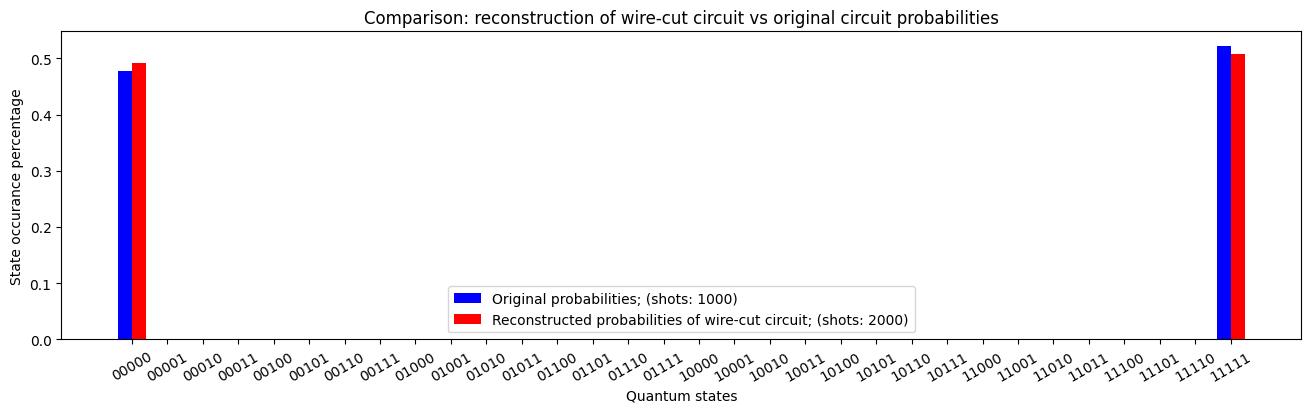

SUCCES


In [ ]:
title: str = "Comparison: reconstruction of wire-cut circuit vs original circuit probabilities"
dataLabels: list = [f"Original probabilities; (shots: {ORG_CIRCUIT_SHOTS})" ,f"Reconstructed probabilities of wire-cut circuit; (shots: {SHOTS_BUDGET})"]
datasets: list = [orgProbs, cutProbs]

qu.ProbabilitesToBarChart(probabilities=datasets, dataLabels=dataLabels, title=title)

result = qwc.EvaluateProbs(orgProbs, cutProbs, 0.1)
if result:
    print("SUCCES")
else:
    print("FAILED")